## Import Library

In [1]:
# Library
import pandas as pd
import datetime

import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from pmdarima.arima.stationarity import ADFTest

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Import Data

Import data from:
https://www.nasdaq.com/market-activity/stocks/amzn/historical

Easily Search find stock symbol you want

Download the csv file and put it into the data folder and you are good!

In [2]:
# Import Data
df = pd.read_csv('data/PG_max.csv')
display(df.head(5))
display(df.tail(5))

,Date,Close/Last,Volume,Open,High,Low
0,12/06/2022,$149.28,6866696,$149.72,$150.08,$148.275
1,12/05/2022,$149.09,5402575,$148.71,$149.6705,$148.27
2,12/02/2022,$150.61,4938278,$148.47,$150.77,$148.08
3,12/01/2022,$149.25,6927461,$149.53,$150.36,$148.57
4,11/30/2022,$149.16,12396780,$145.65,$149.16,$145.13


,Date,Close/Last,Volume,Open,High,Low
2513,12/12/2012,$70.76,8405745,$70.76,$70.99,$70.61
2514,12/11/2012,$70.66,9298121,$70.29,$70.97,$70.14
2515,12/10/2012,$70.22,8124045,$70.12,$70.42,$70.03
2516,12/07/2012,$70.29,11590900,$69.85,$70.66,$69.85
2517,12/06/2012,$69.95,10686820,$69.48,$70.24,$69.44


In [3]:
# Change index to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
# # To uncomment something, you can simply ctrl-'/'
# # Select Time period
# start_date = '2017-12-6'
# end_date = '2021-11-29'
# mask = (df['Date'] > start_date) & (df['Date'] <= end_date)
# df = df.loc[mask]

In [5]:
# Some Data wrangling to make data works
try: 
    # df['Vol.'] = df['Vol.'].apply(lambda x: float(x.strip('M'))*1000000)
    df[df.columns[1:]] = df[df.columns[1:]].replace('[\$,]', '', regex=True).astype(float)
    df = df[::-1].reset_index(drop=True)
    df.rename(columns={'Close/Last':'Close'}, inplace=True)
    df = df.set_index('Date')
except:
    pass
df.head(5)

,Close,Volume,Open,High,Low
Date,,,,,
2012-12-06,69.95,10686820.0,69.48,70.24,69.44
2012-12-07,70.29,11590900.0,69.85,70.66,69.85
2012-12-10,70.22,8124045.0,70.12,70.42,70.03
2012-12-11,70.66,9298121.0,70.29,70.97,70.14
2012-12-12,70.76,8405745.0,70.76,70.99,70.61


## Resampling to obtain weekly stock prices

In [6]:
# Change data to weekly analysis
# Change from 'W' --> 'M' for monthly data

try:
    df_week = df.resample('W').agg({'Open':'first', 
                                    'High':'max', 
                                    'Low': 'min', 
                                    'Close':'last',
                                    'Volume':'max'})
    df_week.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)
    df_week.rename(columns = {'Close': 'Close'}, inplace=True)
except:
    pass
df_week.head(2)

,Close
Date,
2012-12-09,70.29
2012-12-16,69.93


In [7]:
# You can play around using daily data but according to many website due to it's huge period, this would not usually 
# work and it would take forever to for the ARIMA to fit.
try:
    df_daily = df.copy()
    df_daily.index = df.index.to_period('D')
    df_daily.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)
    df_daily.rename(columns = {'Close': 'Close'}, inplace=True)
except:
    pass
df_daily.head(2)

,Close
Date,
2012-12-06,69.95
2012-12-07,70.29


## Split Train/Test Data

In [8]:
# Change this to df_week or df_daily depends on what you want
# Most likely that you will keep this like this
df = df_week 

percent = 0.8 # Split this 80/20
df_training, df_testing = df[:int(len(df)*percent)], df[int(len(df)*percent):]
display(df_training.head(2))
display(df_testing.head(2))
print(df_training.shape[0], df_testing.shape[0])

,Close
Date,
2012-12-09,70.29
2012-12-16,69.93


,Close
Date,
2020-12-13,136.51
2020-12-20,139.04


418 105


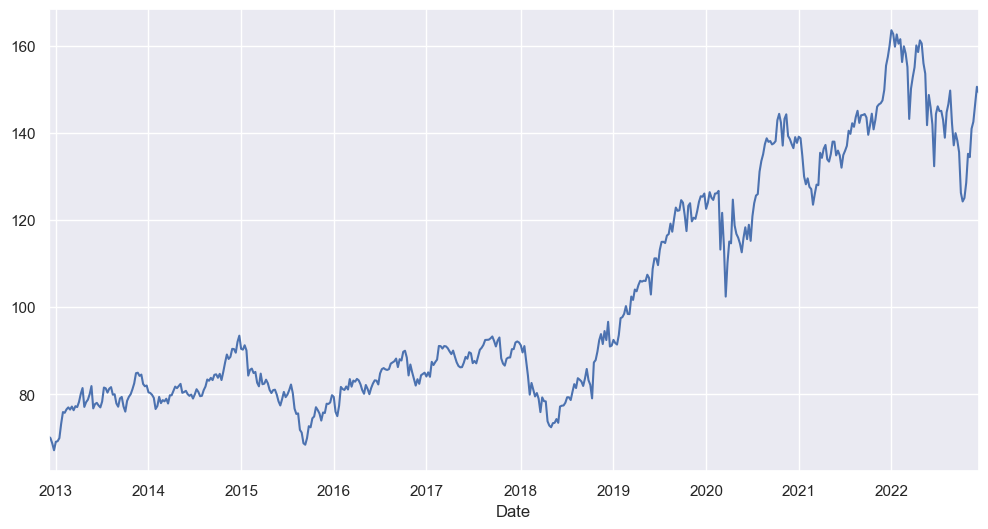

In [9]:
df['Close'].plot(figsize=(12, 6))
plt.show()

# Stationarity

Honestly, I'm not entirely sure too what I'm doing in this part LOL

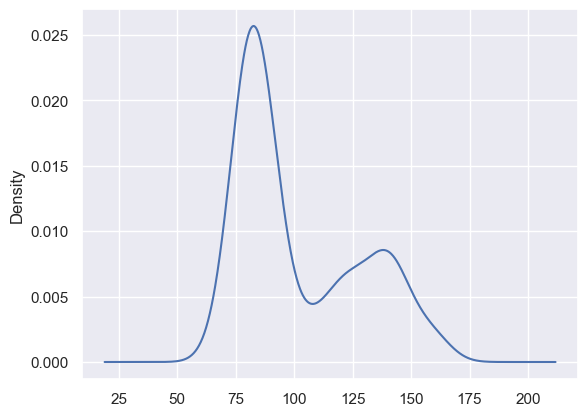

In [10]:
# Distribution
df['Close'].plot(kind='kde')
plt.show()

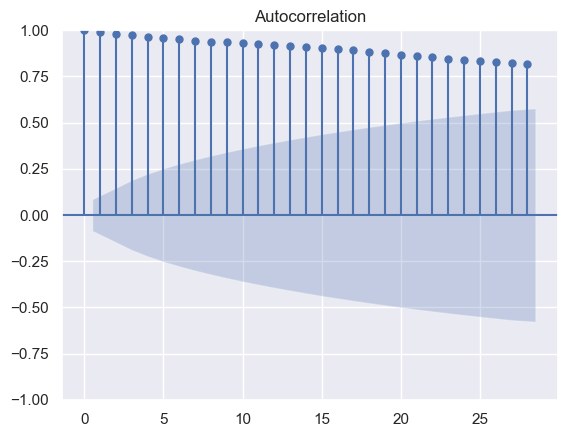

In [11]:
sm.graphics.tsa.plot_acf(df['Close'])

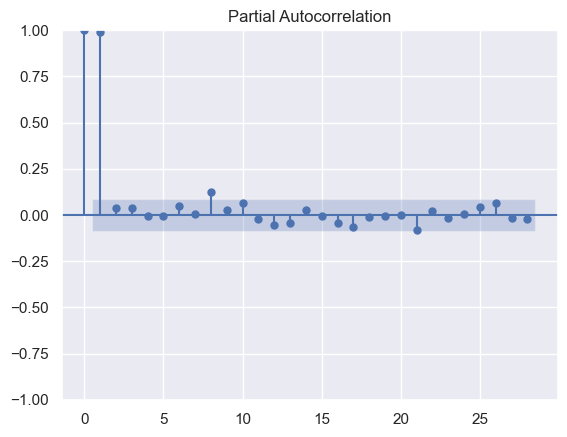

In [12]:
sm.graphics.tsa.plot_pacf(df['Close'], method='ywm')

In [13]:
plt.close('all')

Date
2021-05-23    0.963026
2022-05-22    0.963026
Name: seasonal, dtype: float64
Number of period 364


<Figure size 640x480 with 0 Axes>

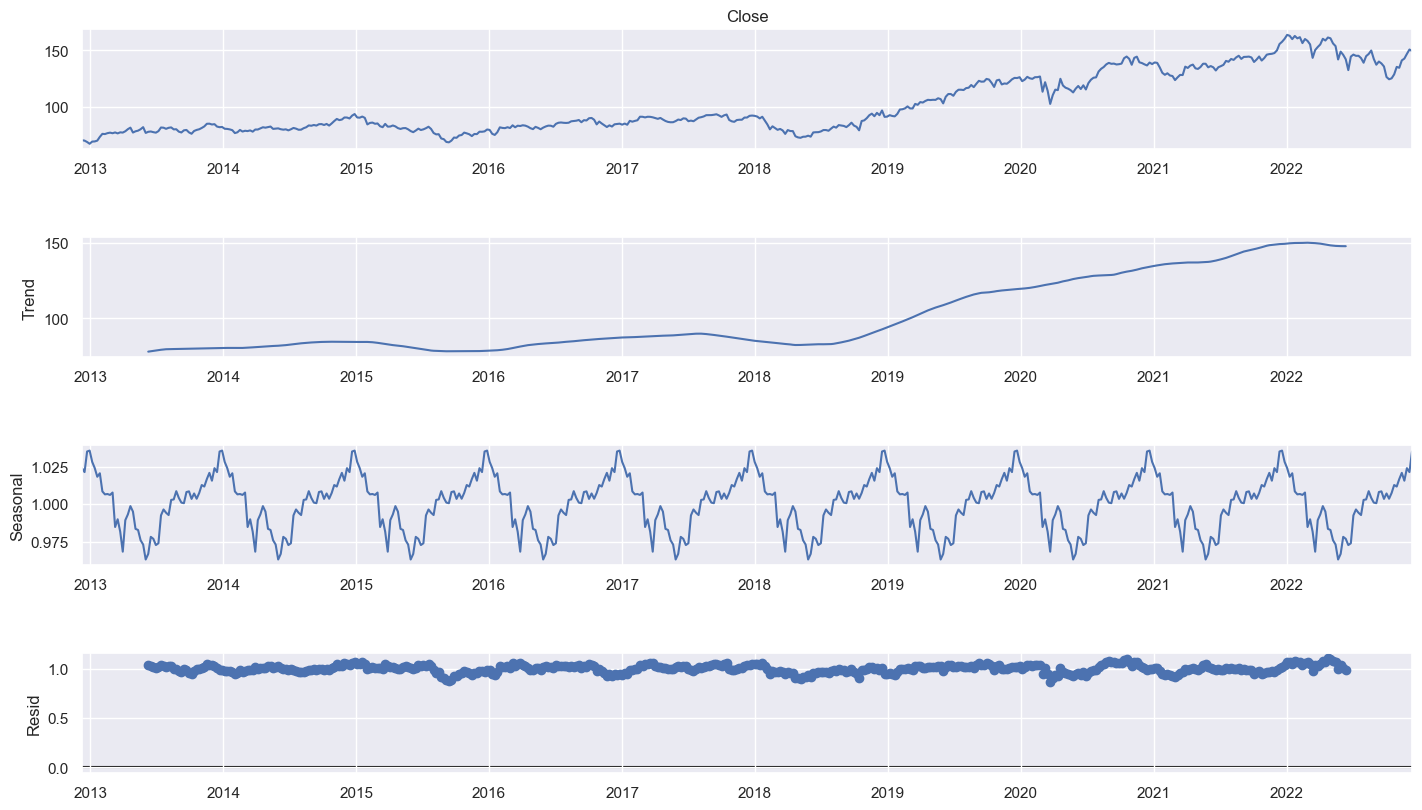

In [14]:
# period of week 52
result = sm.tsa.seasonal_decompose(x = df['Close'], model = 'multiplicative', period = 52)

# # use below when df = daily
# period of day 252 
# df_noperiod = df.copy()
# try:
#     # this is rather for the daily data I was trying to do
#     df_noperiod.index = df_noperiod.index.to_timestamp()
# except:
#     pass
# # result = sm.tsa.seasonal_decompose(x = df_noperiod['Close'], model = 'multiplicative', period = 252) 


# check if period is roughly 1 year
period_list = result.seasonal[result.seasonal == min(result.seasonal)]
print(period_list[-2:])
d0 = period_list[-2:].index[0]
d1 = period_list[-2:].index[1]
delta = d1 - d0
print("Number of period", delta.days)
period = int(delta.days)

# plot the result of seasonal_decompose
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)
plt.show()

In [15]:
# These testing are used for checking if we should have difference in data

adf_test = pm.arima.stationarity.ADFTest(alpha = 0.05)
p_val, should_diff = adf_test.should_diff(df['Close'])
print("%0.3f" % p_val, should_diff)

# Estimate the number of differences using an ADF test:
n_adf = ndiffs(df['Close'], test='adf') 

# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(df['Close'], test='kpss')

# Or a PP test:
n_pp = ndiffs(df['Close'], test='pp')

print(n_adf, n_kpss, n_pp)

0.523 True
1 1 1


In [16]:
# These following tests are used for checking if have to perform seasonal differences

# if df_week
period = 52
# if df_day
# period = 252

# estimate number of seasonal differences using a Canova-Hansen test
D1 = pm.arima.nsdiffs(df_training['Close'],
            m=period,
            max_D=12,
            test='ch')

# or use the OCSB test (by default)
D2 = pm.arima.nsdiffs(df_training['Close'],
                m=period,
                max_D=12,
                test='ocsb')

print("CH:", D1, "ocsb:", D2)

CH: 0 ocsb: 0


An interesting read: <br>
https://stats.stackexchange.com/questions/483182/seasonal-differencing-and-auto-arima

Why stock prices doesn't really have a strong seasonal pattern

## Model Selection

<a href="https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html"> Documentation </a>

In [17]:
## Fitting the model
# d: order of first differencing
# D: order of seasonal differencing
# m: The period for seasonal differencing
# trace: can turn this off to return just the best result

arima_fit = pm.auto_arima(df_training['Close'], error_action='ignore', suppress_warnings=True, 
                          stepwise=False, seasonal=False, trace=True)

# The following code is when you try to force seasonal difference into stock price which usually should not be

# arima_fit = pm.auto_arima(df_training['Close'], error_action='ignore', suppress_warnings=True, 
#                           stepwise=True, 
#                           trace = True,
#                           m=52,
#                           seasonal=True, 
#                           stationary = False,
#                           d = 1, max_d = 10,
#                           D = 1, max_D = 10)

## Printing a summary of the model
print(arima_fit.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1860.598, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1851.796, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1852.799, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1848.896, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1850.750, Time=0.09 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1849.271, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1853.501, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1853.427, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1853.122, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1850.834, Time=0.15 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1843.514, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1850.387, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1850.072, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1851.200, Time=0.21 sec
 ARIMA(3,1,0)(0

In [18]:
print("The best ARIMA fit here is", arima_fit.order)

The best ARIMA fit here is (1, 1, 4)


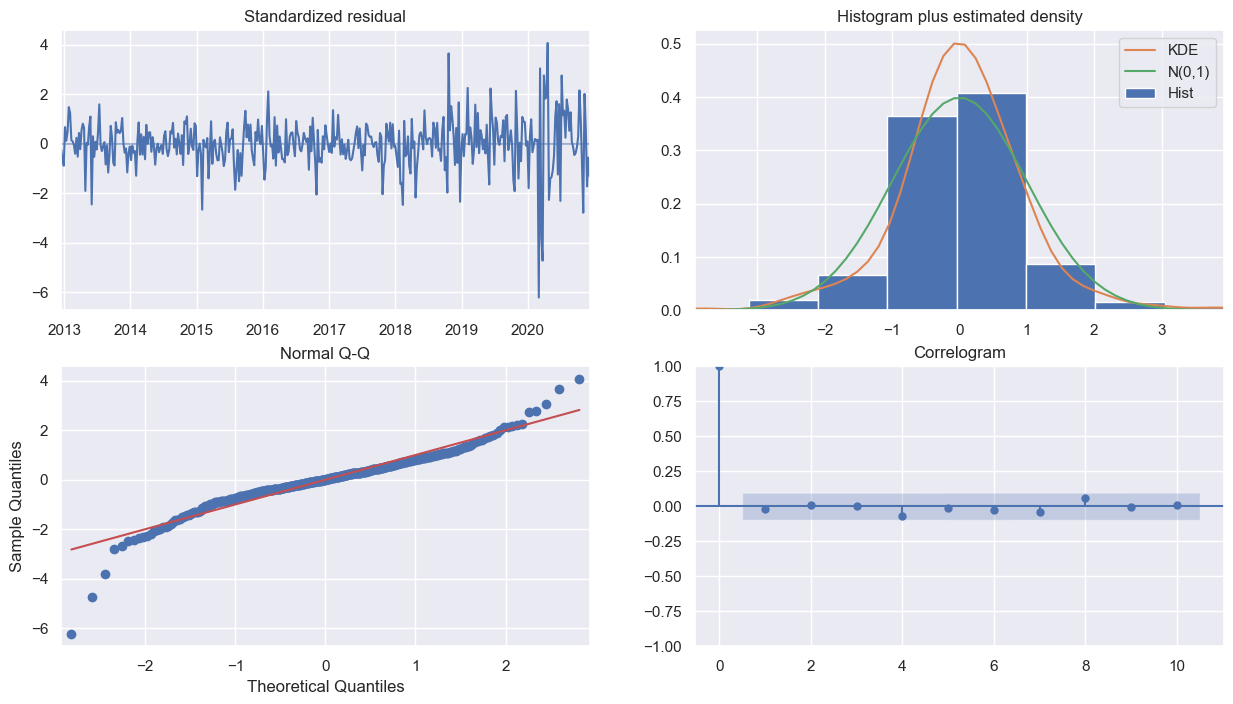

In [19]:
arima_fit.plot_diagnostics(figsize=(15,8))
plt.show()

## Forecast

In [20]:
# Number of forecast which equals testing
n = len(df_testing)
print(len(df_training), len(df_testing))

418 105


In [21]:
# Read more documentation in pmdarima
# alpha here is the confidence interval which is 95%
arima_fcast = arima_fit.predict(n, return_conf_int=True, alpha=0.05)

In [22]:
arima_fcast = [pd.DataFrame(arima_fcast[0], columns=['prediction']),
               pd.DataFrame(arima_fcast[1], columns=['lower_95', 'upper_95']).set_index(arima_fcast[0].index)]

arima_fcast = pd.concat(arima_fcast, axis=1).set_index(df_testing.index)

## Plot the results

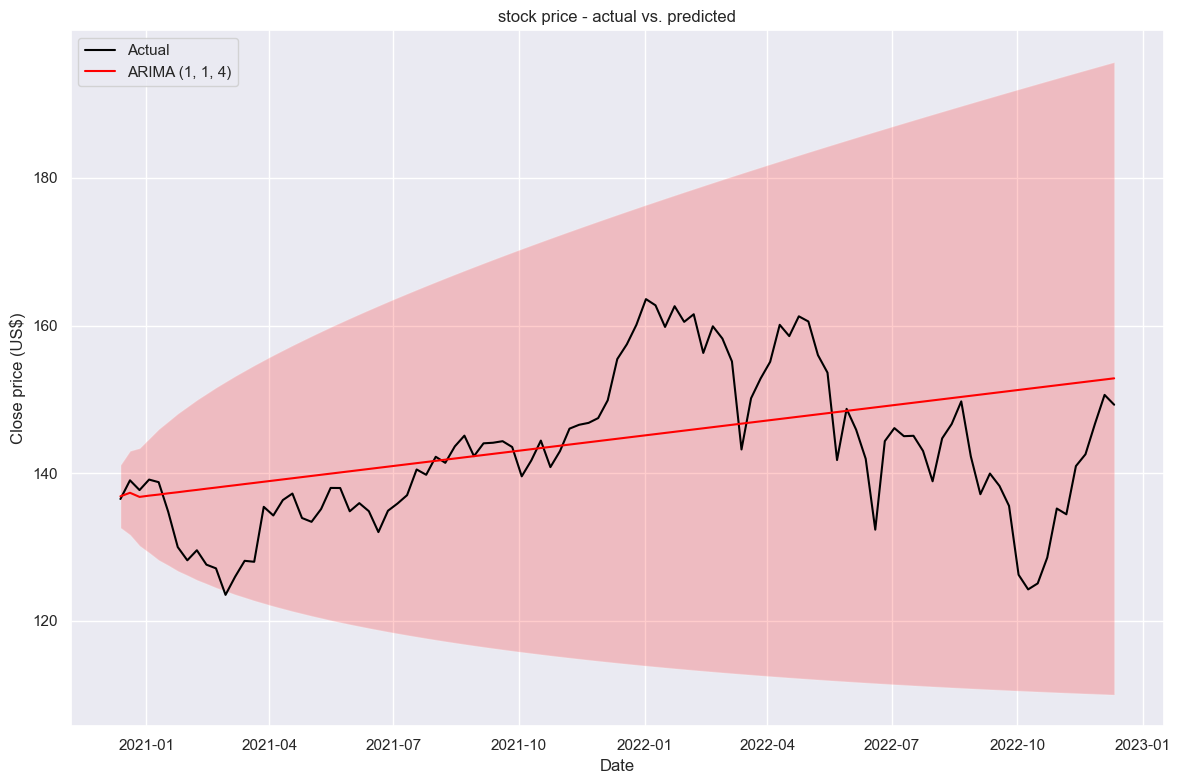

In [23]:
# graph with only the prediction part
fig, ax = plt.subplots(1, figsize=(12, 8))

ax = sns.lineplot(data=df_testing['Close'], color='black', label='Actual')

ax.plot(arima_fcast.prediction, color='red', label='ARIMA '+str(arima_fit.order))

ax.fill_between(arima_fcast.index, 
                arima_fcast.lower_95, 
                arima_fcast.upper_95, 
                alpha=0.2, 
                facecolor='red')

ax.set(title=f"stock price - actual vs. predicted", xlabel='Date',
       ylabel='Close price (US$)')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

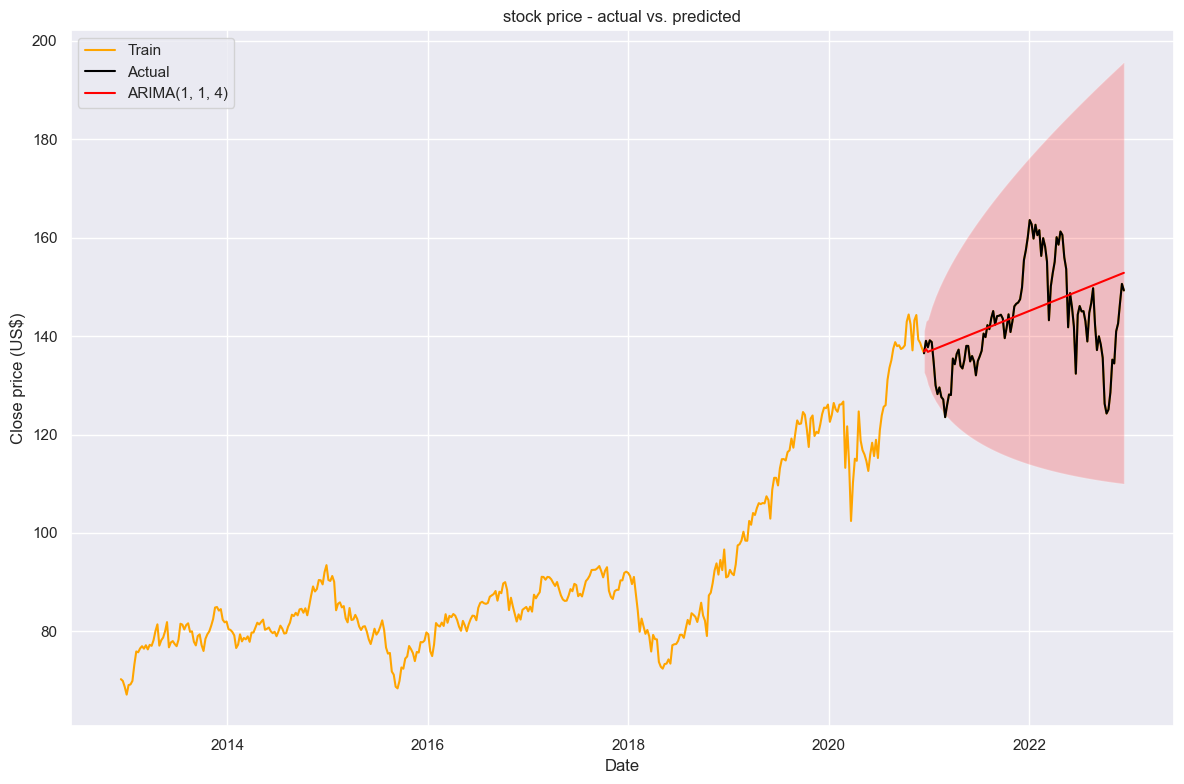

In [24]:
# Graph with the whole data
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(df['Close'], color='orange', label='Train')
ax = sns.lineplot(data=df_testing['Close'], color='black', label='Actual')

ax.plot(arima_fcast.prediction, color='red', label='ARIMA' + str(arima_fit.order))

ax.fill_between(arima_fcast.index, 
                arima_fcast.lower_95, 
                arima_fcast.upper_95, 
                alpha=0.2, 
                facecolor='red')

ax.set(title=f"stock price - actual vs. predicted", xlabel='Date',
       ylabel='Close price (US$)')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Valuation

I'm not entirely sure which is the best valuation of these methods so I pick out the general ones

In [25]:
mse = mean_squared_error(df_testing['Close'], arima_fcast.prediction)
print('MSE: ' + str(mse))
mae = mean_absolute_error(df_testing['Close'], arima_fcast.prediction)
print('MAE: ' + str(mae))
rmse = math.sqrt(mean_squared_error(df_testing['Close'], arima_fcast.prediction))
print('rMSE: ' + str(rmse))
rmae = math.sqrt(mean_absolute_error(df_testing['Close'], arima_fcast.prediction))
print('MAE: ' + str(rmae))

MSE: 93.98185628951838
MAE: 7.4864109142296265
rMSE: 9.694423979253145
MAE: 2.7361306464110275


# Manually ARIMA

There are many thing left to do with manual ARIMA

One can explore further into differencing the data before hands, such as:
1. Log Transform
2. Subtracting Average
3. Differencing the data

The example below works, most you will find online will not work because they use the depreciated ARIMA they are using

What changes here is 'SARIMAX' which is basically you can add in seasonal and external thingy

In [26]:
# trend: Parameter controlling the deterministic trend polynomial

model = sm.tsa.SARIMAX(df_training['Close'], order=(0,1,0), seasonal_order=(1,1,0,12), trend='c')
fitted = model.fit()
print(fitted.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  418
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -986.918
Date:                            Tue, 06 Dec 2022   AIC                           1979.836
Time:                                    20:51:36   BIC                           1991.848
Sample:                                12-09-2012   HQIC                          1984.591
                                     - 12-06-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0024      0.140     -0.017      0.986      -0.277       0.272
ar.S.L12      -0.4279      0.034   

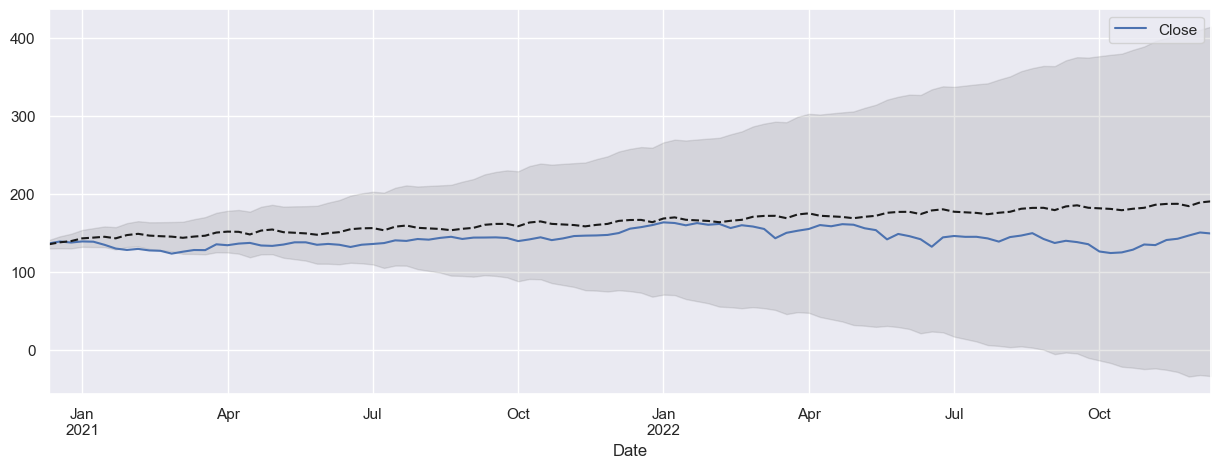

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data 
df_testing.plot(ax=ax)
# uncomment this to get graph of the whole data
# df_training.plot(ax=ax)

# Construct the forecasts
fcast = fitted.get_forecast(len(df_testing)).summary_frame(alpha=0.05)
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.show()

In [28]:
mse = mean_squared_error(df_testing['Close'], fcast['mean'])
print('MSE: ' + str(mse))
mae = mean_absolute_error(df_testing['Close'], fcast['mean'])
print('MAE: ' + str(mae))
rmse = math.sqrt(mean_squared_error(df_testing['Close'], fcast['mean']))
print('rMSE: ' + str(rmse))
rmae = math.sqrt(mean_absolute_error(df_testing['Close'], fcast['mean']))
print('MAE: ' + str(rmae))

MSE: 650.5422009261212
MAE: 21.5016891565191
rMSE: 25.505728786414263
MAE: 4.636991390602219


# SOURCES

https://www.nasdaq.com/market-activity/stocks/amzn/historical <br>
https://alkaline-ml.com/pmdarima/index.html <br>
https://www.statsmodels.org/dev/index.html <br>
https://www.linkedin.com/pulse/time-series-part-3-stock-price-prediction-using-arima-agarwal/?trk=articles_directory